# Notebook to process Trios data from the mission on the Thau lagoon (fall 2022)

In [1]:
import os
import numpy as np, pandas as pd, xarray as xr
import pandas_access as pda
import glob
import re
import datetime

from scipy.interpolate import interp1d
#import suncalc

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

rc = {"font.family": "serif", "mathtext.fontset": "stix", 'font.size': 16, 'axes.labelsize': 18}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]


from trios import __version__
from trios import awr_process, iwr_process, swr_process, utils
opj = os.path.join
__version__

'1.0.1'

### Get and reshape the data

In [2]:
def reformat(_, wl_common):
    record = _['Data'].transform(lambda x: x.split('\r\n '))
    # transpose measurement values per wavelength
    wls = np.array([x.split(' ')[0] for x in record.values[0] if x.split(' ')[0] not in (u'', u'0')])
    data = np.array([x.split(' ')[1] for x in record.values[0] if x.split(' ')[0] in wls])
    wl = wls.astype('float')
    data = data.astype('float')

    return interp1d(wl, data, fill_value='extrapolate')(wl_common)

In [3]:
DBfile = '/home/harmel/Dropbox/Dropbox/work/projet/magellium/malaigue/data/thau_jun2023/dataTriOS_2022-09-14.mdb'

# set common wavelengths on which spectra are reprojected
# default 320nm to 950 nm each wl_step nm
wl_step = 3
wl_common = np.arange(320,950+wl_step,wl_step)

df = pda.read_table(DBfile, 'tblData')
query = (df.IDDataType == 'SPECTRUM') & (df.IDDataTypeSub1 == 'CALIBRATED')
df = df[query]

In [4]:
df['datetime']=pd.to_datetime(df.DateTime)
df.set_index('datetime')

IDData  Version  IDDevice  \
datetime                                                                   
2019-09-11 09:48:39  0474_2019-09-11_09-48-38_664_043        1  SAM_8535   
2019-09-11 09:48:39  0474_2019-09-11_09-48-38_664_046        1  SAM_85CF   
2019-09-11 09:48:41  0474_2019-09-11_09-48-40_664_049        1  SAM_8535   
2019-09-11 09:48:42  0474_2019-09-11_09-48-41_664_052        1  SAM_85CF   
2019-09-11 09:48:43  0474_2019-09-11_09-48-42_664_055        1  SAM_8535   
...                                               ...      ...       ...   
2023-06-23 15:25:12  0474_2023-06-23_15-25-11_963_386        1  SAM_85CF   
2023-06-23 15:25:15  0474_2023-06-23_15-25-14_963_392        1  SAM_8553   
2023-06-23 15:25:15  0474_2023-06-23_15-25-14_963_396        1  SAM_85CF   
2023-06-23 15:25:18  0474_2023-06-23_15-25-17_963_402        1  SAM_85CF   
2023-06-23 15:25:18  0474_2023-06-23_15-25-17_963_405        1  SAM_8553   

                    IDDataType IDDataTypeSub1 IDDataTypeSub2 IDDataTypeSub3  \
datetime                                                                      
2019-09-11 09:48:39   SPECTRUM     CALIBRATED            NaN            NaN   
2019-09-11 09:48:39   SPECTRUM     CALIBRATED            NaN            NaN   
2019-09-11 09:48:41   SPECTRUM     CALIBRATED            NaN            NaN   
2019-09-11 09:48:42   SPECTRUM     CALIBRATED            NaN            NaN   
2019-09-11 09:48:43   SPECTRUM     CALIBRATED            NaN            NaN   
...                        ...            ...            ...            ...   
2023-06-23 15:25:12   SPECTRUM     CALIBRATED            NaN            NaN   
2023-06-23 15:25:15   SPECTRUM     CALIBRATED            NaN            NaN   
2023-06-23 15:25:15   SPECTRUM     CALIBRATED            NaN            NaN   
2023-06-23 15:25:18   SPECTRUM     CALIBRATED            NaN            NaN   
2023-06-23 15:25:18   SPECTRUM     CALIBRATED            NaN            NaN   

                     MethodName   IDMethodType           DateTime  ...  \
datetime                                                           ...   
2019-09-11 09:48:39    SAM_8535    SAM Control  09/11/19 09:48:39  ...   
2019-09-11 09:48:39    SAM_85CF    SAM Control  09/11/19 09:48:39  ...   
2019-09-11 09:48:41    SAM_8535    SAM Control  09/11/19 09:48:41  ...   
2019-09-11 09:48:42    SAM_85CF    SAM Control  09/11/19 09:48:42  ...   
2019-09-11 09:48:43    SAM_8535    SAM Control  09/11/19 09:48:43  ...   
...                         ...            ...                ...  ...   
2023-06-23 15:25:12    SAM_85CF    SAM Control  06/23/23 15:25:12  ...   
2023-06-23 15:25:15  SAMIP_50CD  SAMIP Control  06/23/23 15:25:15  ...   
2023-06-23 15:25:15    SAM_85CF    SAM Control  06/23/23 15:25:15  ...   
2023-06-23 15:25:18    SAM_85CF    SAM Control  06/23/23 15:25:18  ...   
2023-06-23 15:25:18  SAMIP_50CD  SAMIP Control  06/23/23 15:25:18  ...   

                     Comment  CommentSub1 CommentSub2 CommentSub3 RecordType  \
datetime                                                                       
2019-09-11 09:48:39      NaN  above water          Lt       id_pr          0   
2019-09-11 09:48:39      NaN  above water        Lsky       id_pr          0   
2019-09-11 09:48:41      NaN  above water          Lt       id_pr          0   
2019-09-11 09:48:42      NaN  above water        Lsky       id_pr          0   
2019-09-11 09:48:43      NaN  above water          Lt       id_pr          0   
...                      ...          ...         ...         ...        ...   
2023-06-23 15:25:12      NaN         Lu0+        Lu0+    _TH_PR21          0   
2023-06-23 15:25:15      NaN         Lu0+          Ed    _TH_PR21          0   
2023-06-23 15:25:15      NaN         Lu0+        Lu0+    _TH_PR21          0   
2023-06-23 15:25:18      NaN         Lu0+        Lu0+    _TH_PR21          0   
2023-06-23 15:25:18      NaN         Lu0+          Ed    _TH_PR21          0   

                          

In [5]:
columns = pd.MultiIndex.from_product([['Lu'], wl_common]).append(
        pd.MultiIndex.from_product([['Ed'], wl_common])).set_names(['param', 'wl'])
trios=[]
for ID_,df_ in df.groupby('CommentSub3'): 
    if 'TH' not in ID_:
        continue
    # remove duplicated samples
    if ID_ == '_TH_PR12_b':
        continue
    if 'underwater' in ID_:
        continue
    site,ID = ID_.split('_')[1:3]
    data, dates = [], []
    for date, df__ in df_.groupby('datetime'):
        info = df__[['Comment','CommentSub1','CommentSub2','CommentSub3']].to_numpy()[0]


        if date.year < 2023:
            continue

        # (here filter out in-water measurements)

        if pd.isnull(info).all() or 'Lu0+' not in info[1]:
            #print(date, df_[['Comment','CommentSub1','CommentSub2','CommentSub3']])
            continue

        # get full acquisition set (3 meas: Lt, Lsky, Ed)
        if df__.shape[0] < 2:
            continue
        
        dates.append(date)

        Lu_ = reformat(df__[df__['CommentSub2'] == 'Lu0+'], wl_common)
        Ed_ = reformat(df__[df__['CommentSub2'] == 'Ed'], wl_common)

        data.append(np.concatenate([Lu_, Ed_]))
    trios_ = pd.DataFrame(data, columns=columns, index=pd.Index(dates, name='date')).stack().to_xarray()
    trios_['ID']=int(ID.replace('PR',''))
    trios_['site']=site
    trios.append(trios_)

In [6]:
xr.set_options(display_style='html')
xtrios = xr.concat(trios,dim='ID')
xtrios

<xarray.Dataset>
Dimensions:  (date: 290, wl: 211, ID: 10)
Coordinates:
  * date     (date) datetime64[ns] 2023-06-22T10:52:56 ... 2023-06-23T15:25:18
  * wl       (wl) int64 320 323 326 329 332 335 338 ... 935 938 941 944 947 950
  * ID       (ID) int64 12 13 14 15 16 17 18 19 20 21
Data variables:
    Ed       (ID, date, wl) float64 3.646 4.792 5.936 ... 165.4 166.2 174.5
    Lu       (ID, date, wl) float64 0.003916 0.004993 0.006071 ... 1.06 1.079
    site     (ID) <U2 'TH' 'TH' 'TH' 'TH' 'TH' 'TH' 'TH' 'TH' 'TH' 'TH'

In [7]:
xtrios['Rrs']=(xtrios.Lu/xtrios.Ed)
xRrs = xtrios.Rrs.quantile(0.10,'date')#.dropna(dim='ID',how='all')
xRrs = xRrs.where(xRrs>0,0)

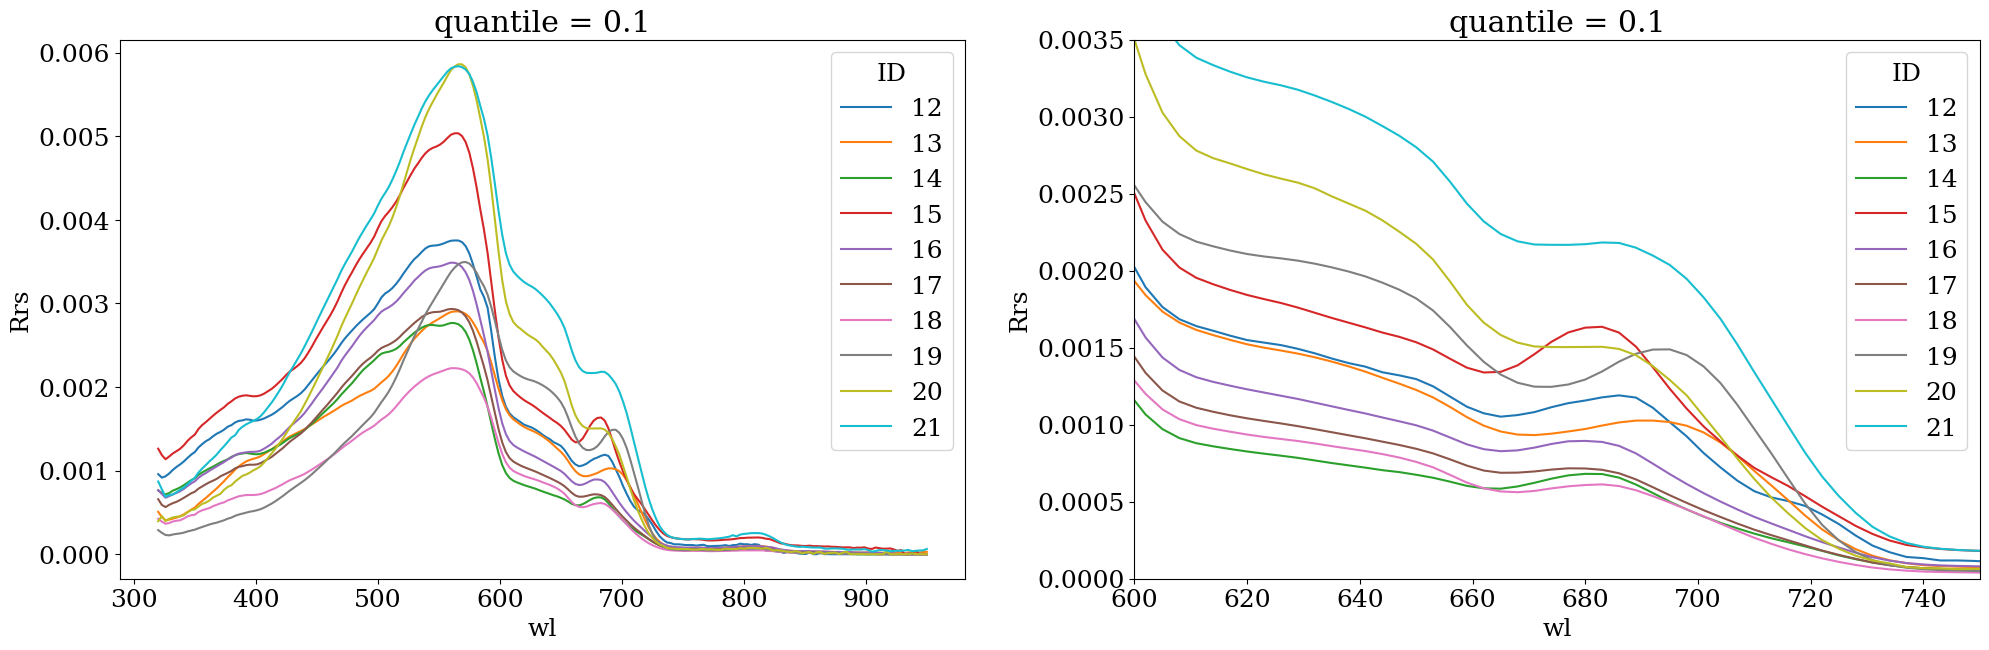

In [8]:
fig,axs=plt.subplots(1,2,figsize=(24,7))
xRrs.plot(hue='ID',ax=axs[0])
xRrs.plot(hue='ID',ax=axs[1])
axs[1].set_xlim(600,750)
axs[1].set_ylim(0,0.0035)
plt.show()

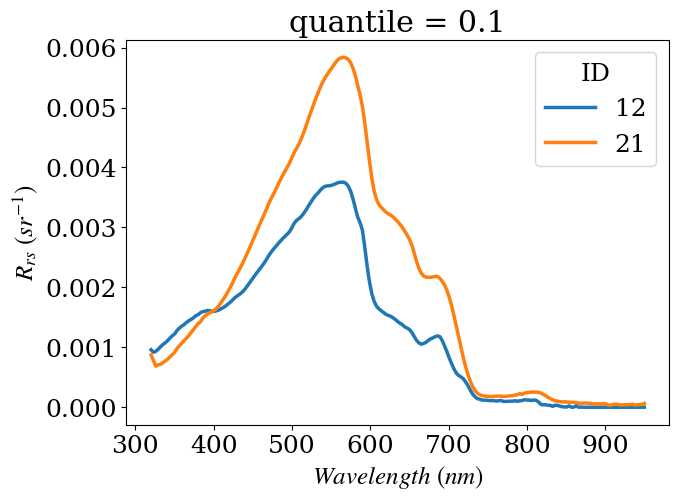

In [22]:
fig,axs=plt.subplots(1,1,figsize=(7,5))
xRrs.sel(ID=[12,21]).plot(hue='ID',ax=axs,lw=2.5)
plt.xlabel('$Wavelength\ (nm)$')

 
  
plt.ylabel('$R_{rs}\ (sr^{-1})$')
plt.show()

In [15]:
xRrs.to_netcdf('/DATA/git/insitu_app/shallowat/surfwater_trios.nc')

In [2]:
    trios = pd.DataFrame(data, columns=columns, index=pd.Index(dates, name='date'))
    trios[trios == '-NAN'] = np.nan
    # trios= trios.dropna(axis=1)

    ID = os.path.basename(DBfile).split('-')[-1].replace('.mdb', '')
    date_ = dt.datetime.strptime(date, '%m/%d/%y %H:%M:%S').strftime('%Y%m%d')

    # reformat ID to be generic 'Pt00.'
    import re

    ID = ID.capitalize()
    ID__ = ID_ = re.search('(\d+)', ID).group(1)
    if len(ID_) == 1:
        ID_ = '0' + ID_
    ID = ID.replace(ID__, ID_)

    trios['ID'] = ID
    trios['lat'] = coords[coords.ID == ID].lat.values[0]
    trios['lon'] = coords[coords.ID == ID].lon.values[0]

    ofile = opj(odir, 'trios_' + date_ + '_' + ID + '_' + suffix + '.csv')
    trios.to_csv(ofile)

rep
ID         
2    TH_PR2
3    TH_PR3
4    TH_PR4
5    TH_PR5
6    TH_PR6
7    TH_PR7
8    TH_PR8
9    TH_PR9
10  TH_PR10
11  TH_PR11

### Start with one given sample

In [89]:
id = 7
rep =idpr.loc[id].rep
files= glob.glob(opj(datadir,rep,'*'))
files

['/home/harmel/Dropbox/Dropbox/work/projet/magellium/malaigue/data/thau_nov2022/trios/TH_PR7/TH_PR7 _Lt.xlsx',
 '/home/harmel/Dropbox/Dropbox/work/projet/magellium/malaigue/data/thau_nov2022/trios/TH_PR7/TH_PR7 _Rrs.xlsx',
 '/home/harmel/Dropbox/Dropbox/work/projet/magellium/malaigue/data/thau_nov2022/trios/TH_PR7/TH_PR7 _Ls.xlsx',
 '/home/harmel/Dropbox/Dropbox/work/projet/magellium/malaigue/data/thau_nov2022/trios/TH_PR7/TH_PR7 _ed.xlsx']

#### Implement a reader for your format to get xarray with dates and wavelength dimenions

In [90]:
def reshape_data(file,common_wl=None,name=''):
    data = pd.read_excel(file,index_col=0).dropna()
    data = data.drop(['mean','stdv'],axis=1).T
    data.index=pd.to_datetime(data.index)
    data = data.stack()
    data.index.names=['date','wl']
    data = data.to_xarray()
    data.name=name
    if common_wl:
        data = data.interp(wl=common_wl)
    return data

In [91]:
# set common wavelengths to reproject on:
common_wl = np.array([319, 322, 326, 329, 332, 336, 339, 342, 346, 349, 352, 356, 359, 362,
       366, 369, 372, 376, 379, 382, 386, 389, 392, 396, 399, 402, 406, 409,
       412, 416, 419, 422, 426, 429, 432, 436, 439, 442, 446, 449, 452, 456,
       459, 462, 466, 469, 472, 476, 479, 482, 486, 489, 492, 496, 499, 502,
       506, 509, 513, 516, 519, 523, 526, 529, 533, 536, 539, 543, 546, 549,
       553, 556, 559, 563, 566, 569, 573, 576, 579, 583, 586, 589, 593, 596,
       599, 603, 606, 609, 613, 616, 620, 623, 626, 630, 633, 636, 640, 643,
       646, 650, 653, 656, 660, 663, 666, 670, 673, 676, 680, 683, 686, 690,
       693, 696, 700, 703, 706, 710, 713, 716, 720, 723, 726, 730, 733, 736,
       739, 743, 746, 749, 753, 756, 759, 763, 766, 769, 773, 776, 779, 783,
       786, 789, 793, 796, 799, 802, 806, 809, 812, 816, 819, 822, 826, 829,
       832, 836, 839, 842, 845, 849, 852, 855, 859, 862, 865, 868, 872, 875,
       878, 882, 885, 888, 891, 895, 898, 901, 905, 908, 911, 914, 918, 921,
       924, 927, 931, 934, 937, 940, 944, 947, 950])
# set file paths
Edfile = opj(datadir,rep,rep+' _ed.xlsx')
Lsfile = opj(datadir,rep,rep+' _Ls.xlsx')
Ltfile = opj(datadir,rep,rep+' _Lt.xlsx')
# open and merge
data = xr.merge([reshape_data(Edfile,name='Ed'),
          reshape_data(Lsfile,name='Ls'),
          reshape_data(Ltfile,name= 'Lt')])
data

<xarray.Dataset>
Dimensions:  (date: 29, wl: 191)
Coordinates:
  * date     (date) datetime64[ns] 2022-11-30T11:34:43 ... 2022-11-30T11:39:23
  * wl       (wl) int64 319 322 326 329 332 336 339 ... 934 937 940 944 947 950
Data variables:
    Ed       (date, wl) float64 61.19 80.44 99.61 116.0 ... 99.18 100.5 104.1
    Ls       (date, wl) float64 6.966 9.246 12.28 15.38 ... 0.5789 0.6258 nan
    Lt       (date, wl) float64 0.2839 0.3722 0.4825 ... 0.01787 0.0185 0.01637

#### Get Sun zenith angles, you need to know lon, lat and UTC time:


In [92]:
sun = suncalc.get_position(data.date,lon, lat)
sza=90-np.degrees(sun['altitude'])
data['sza'] = ('date',sza.values)

In [93]:
data.sza

<xarray.DataArray 'sza' (date: 29)>
array([65.01836691, 65.01841508, 65.01848583, 65.01857914, 65.01869502,
       65.01883347, 65.01899448, 65.01917807, 65.01938422, 65.01961294,
       65.01986422, 65.02013807, 65.02043449, 65.02075348, 65.02109503,
       65.02145914, 65.02184582, 65.02225507, 65.02268688, 65.02314125,
       65.02361818, 65.02411768, 65.02463974, 65.02518437, 65.02575155,
       65.02634129, 65.0269536 , 65.02758846, 65.02824588])
Coordinates:
  * date     (date) datetime64[ns] 2022-11-30T11:34:43 ... 2022-11-30T11:39:23

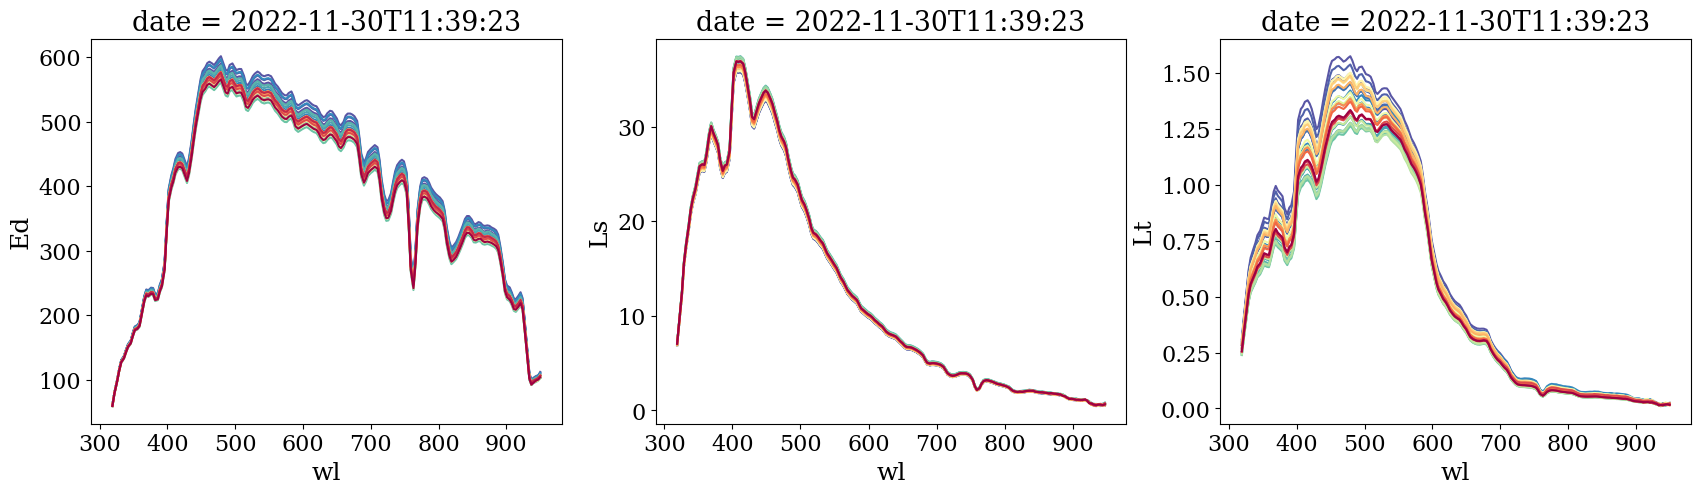

In [94]:
import matplotlib as mpl
cmap = plt.cm.Spectral_r
norm = mpl.colors.Normalize(vmin=np.min(data.sza),vmax=np.max(data.sza))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.subplots_adjust(left=0.1, right=0.9, hspace=.1, wspace=0.2)
#axs.minorticks_on()
for sza,data_ in data.groupby('sza'):
    data_.Ed.plot(c=cmap(norm(sza)),ax=axs[0],add_legend=False)
    data_.Ls.plot(c=cmap(norm(sza)),ax=axs[1],add_legend=False)
    data_.Lt.plot(c=cmap(norm(sza)),ax=axs[2],add_legend=False)
plt.show()

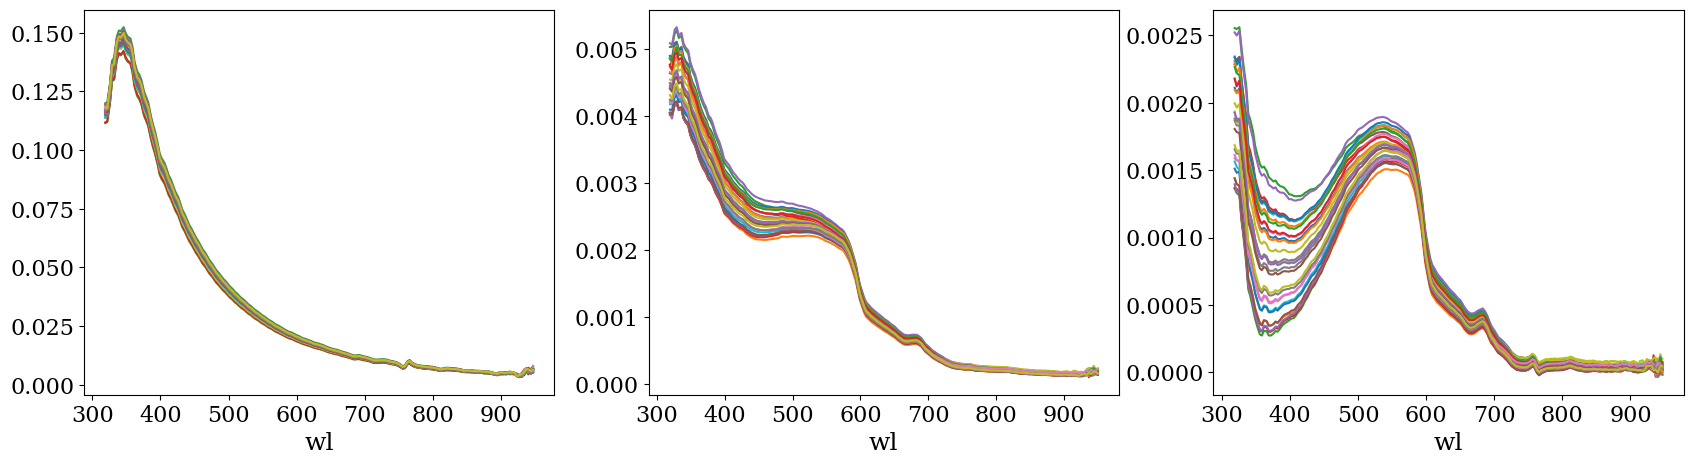

In [95]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.subplots_adjust(left=0.1, right=0.9, hspace=.1, wspace=0.2)
(data.Ls/data.Ed).plot(hue='date',ax=axs[0],add_legend=False)
(data.Lt/data.Ed).plot(hue='date',ax=axs[1],add_legend=False)
((data.Lt-0.0222*data.Ls)/data.Ed).plot(hue='date',ax=axs[2],add_legend=False)

plt.show()

In [96]:
awr_fine = awr_process(wl=common_wl, aerosol = 'fine')
rho = awr_fine.get_rho_values #(60,40,135,wl=common_wl)
rho_mobley = awr_fine.get_rho_mobley
rho_mobley  = awr_fine.rhoM1999.to_xarray().rho

/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


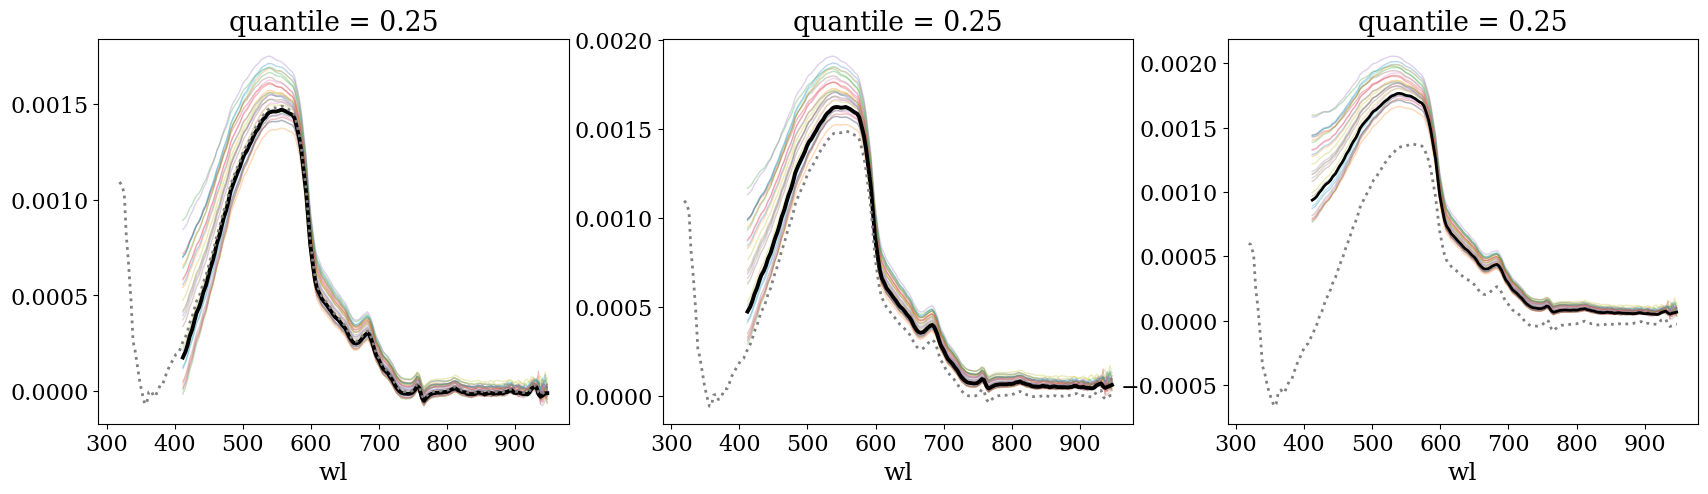

In [97]:
sza = data.sza.mean()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.subplots_adjust(left=0.1, right=0.9, hspace=.1, wspace=0.2)


azi=135
vza=40
rho_M = rho_mobley.sel(wind=2).sel(azi=azi,vza=vza,method='nearest').interp(sza=sza,method='quadratic')
Rrs=(data.Lt-rho(sza,vza,azi,wl=common_wl)*data.Ls)/data.Ed
Rrs_M=(data.Lt-rho_M*data.Ls)/data.Ed
Rrs.plot(hue='date',add_legend=False,lw=1,ax=axs[0],alpha=0.3)
Rrs.quantile(0.25,dim='date').plot(c='k',lw=2.8,ax=axs[0])
Rrs_M.quantile(0.25,dim='date').plot(c='gray',ls=':',lw=2.,ax=axs[0],label='rho_M')

azi=90
vza=40
rho_M = rho_mobley.sel(wind=2).sel(azi=azi,vza=vza,method='nearest').interp(sza=sza,method='quadratic')
Rrs=(data.Lt-rho(sza,vza,azi,wl=common_wl)*data.Ls)/data.Ed
Rrs_M=(data.Lt-rho_M*data.Ls)/data.Ed
Rrs.plot(hue='date',add_legend=False,lw=1,ax=axs[1],alpha=0.3,label=None)
Rrs.quantile(0.25,dim='date').plot(c='k',lw=2.8,ax=axs[1])
Rrs_M.quantile(0.25,dim='date').plot(c='gray',ls=':',lw=2.,ax=axs[1],label='rho_M')

wind=8
rho_M = rho_mobley.sel(wind=wind).sel(azi=azi,vza=vza,method='nearest').interp(sza=sza,method='quadratic')
Rrs=(data.Lt-rho(sza,vza,azi,ws=[wind],wl=common_wl)*data.Ls)/data.Ed
Rrs_M=(data.Lt-rho_M*data.Ls)/data.Ed

Rrs.plot(hue='date',add_legend=False,lw=1,ax=axs[2],alpha=0.3)
Rrs.quantile(0.25,dim='date').plot(c='k',lw=2.,ax=axs[2],label='rho_h')
Rrs_M.quantile(0.25,dim='date').plot(c='gray',ls=':',lw=2.,ax=axs[2],label='rho_M')


plt.show()

## Putting all together, process all the stations and save results into netcdf file

TH_PR2


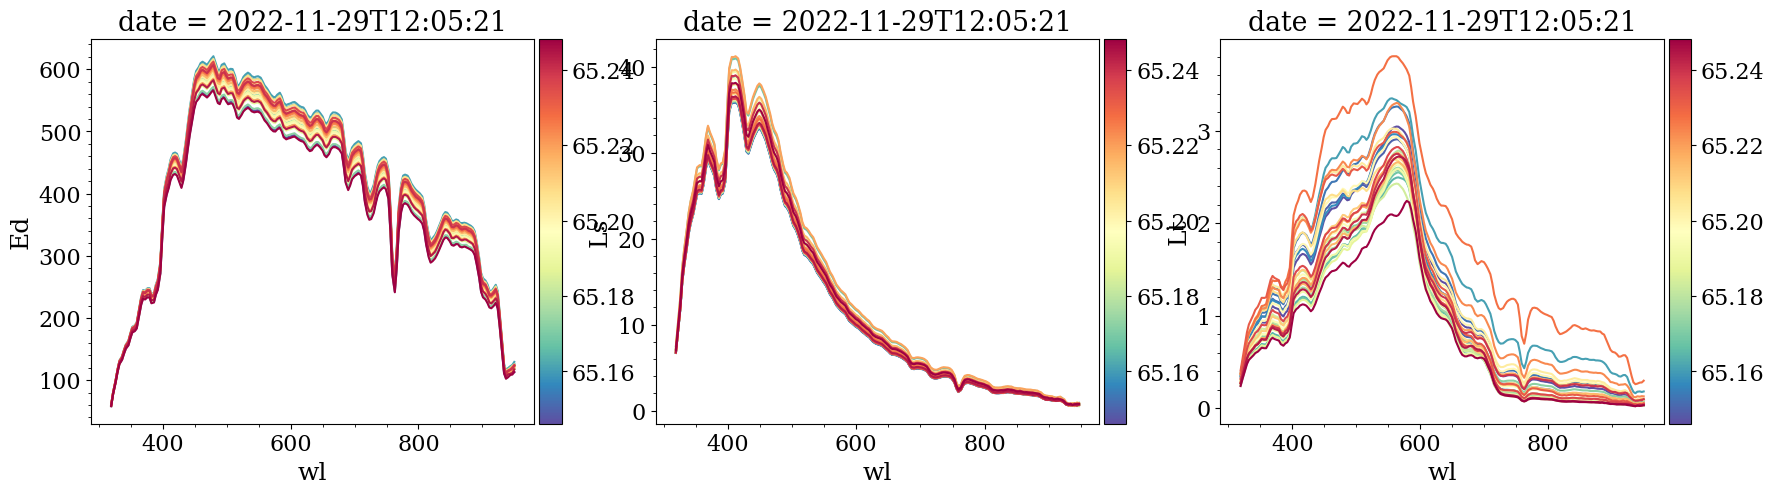

/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


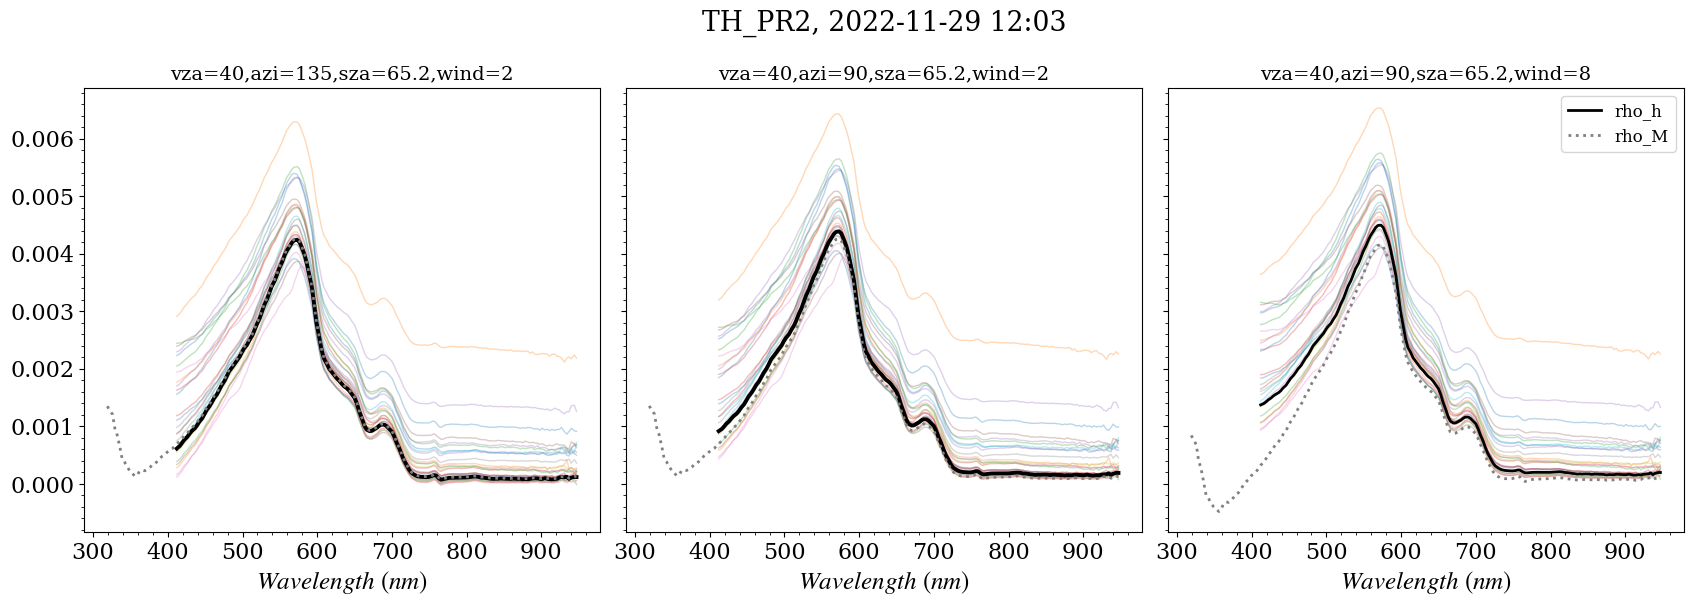

TH_PR3


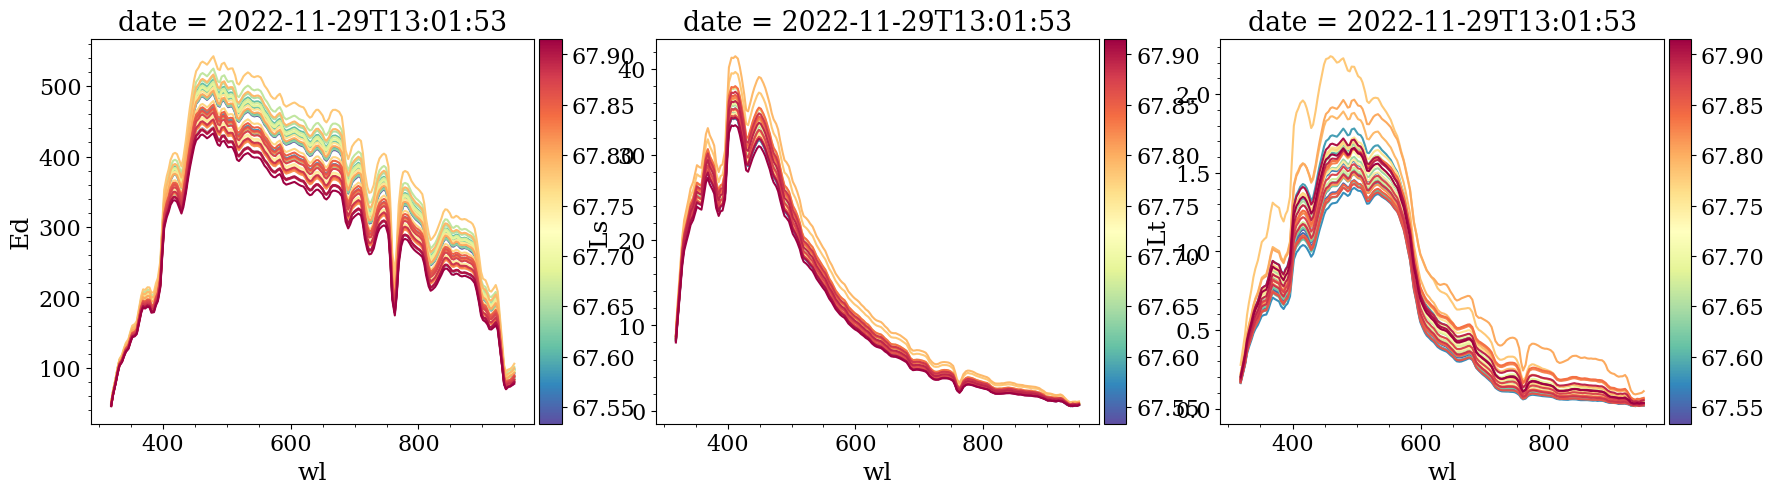

/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


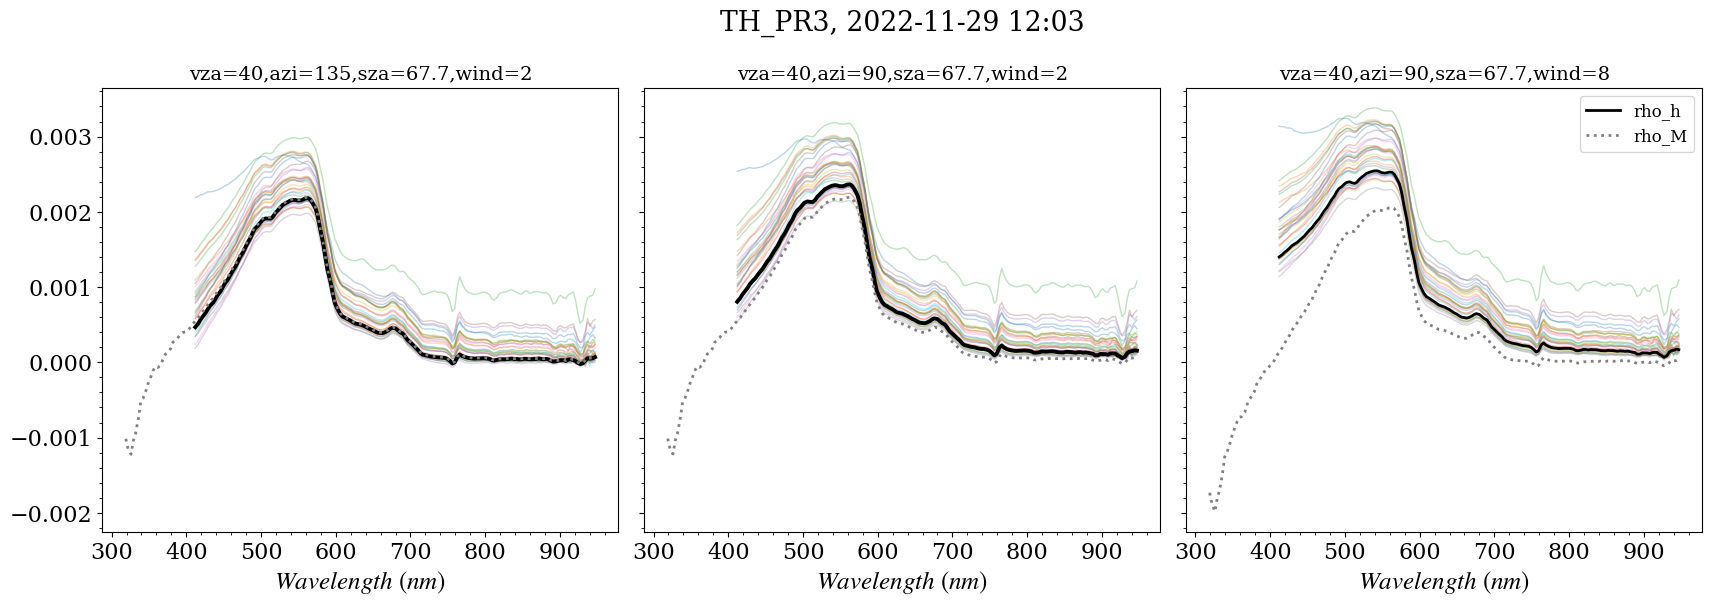

TH_PR4


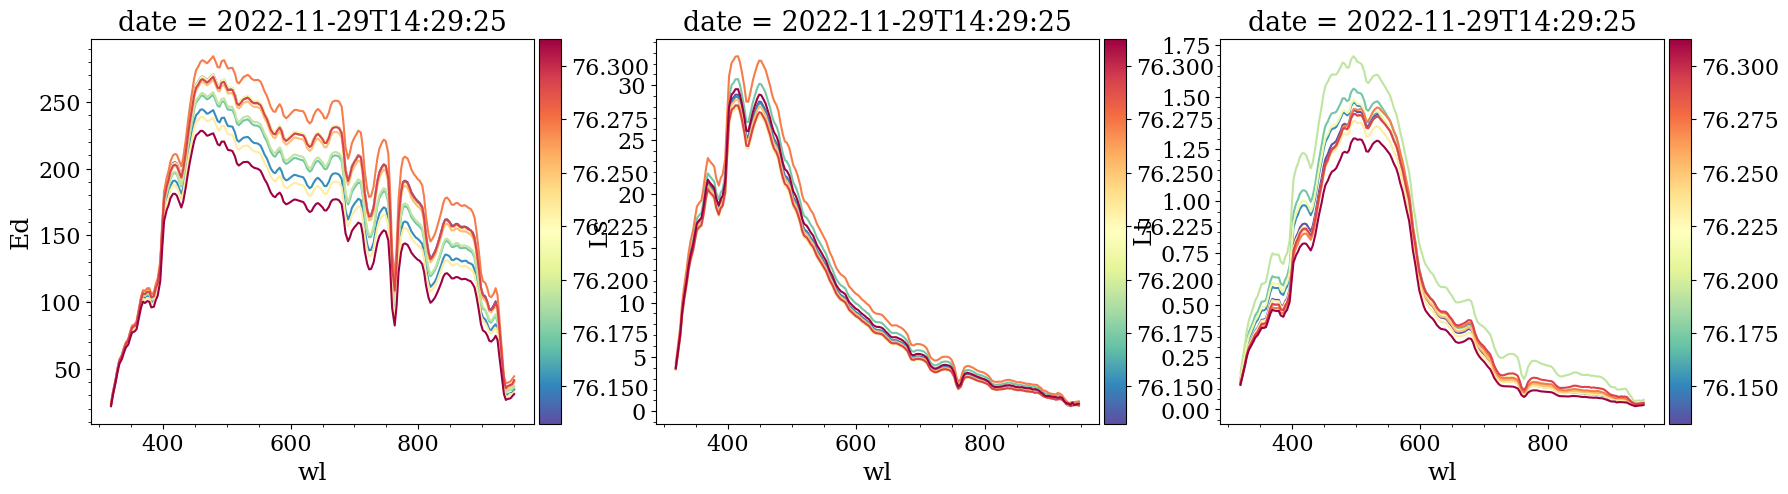

/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


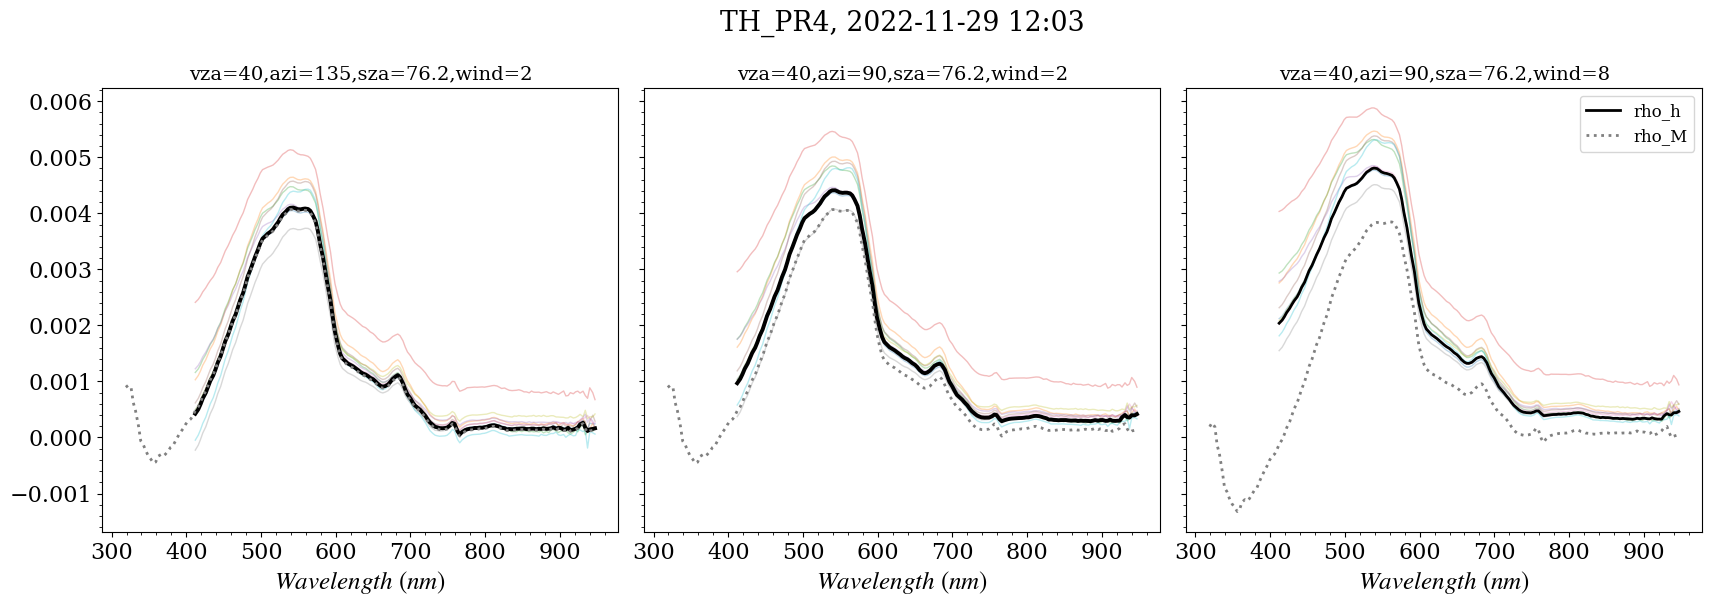

TH_PR5


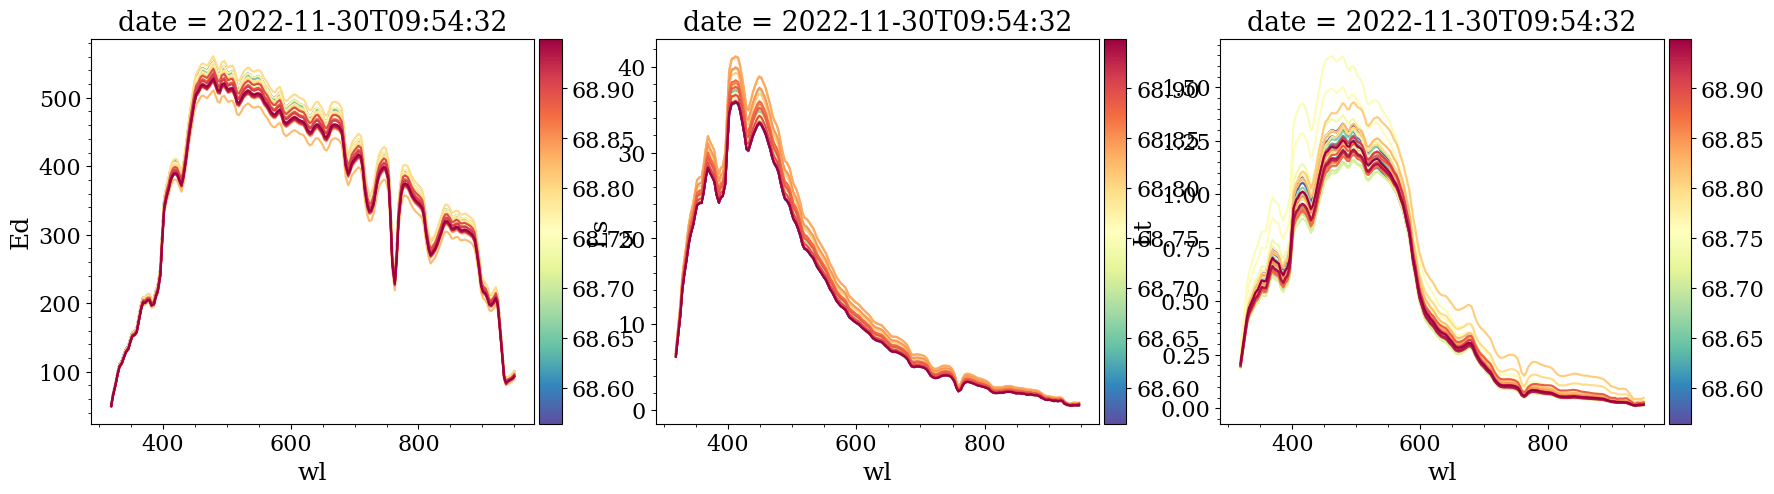

/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


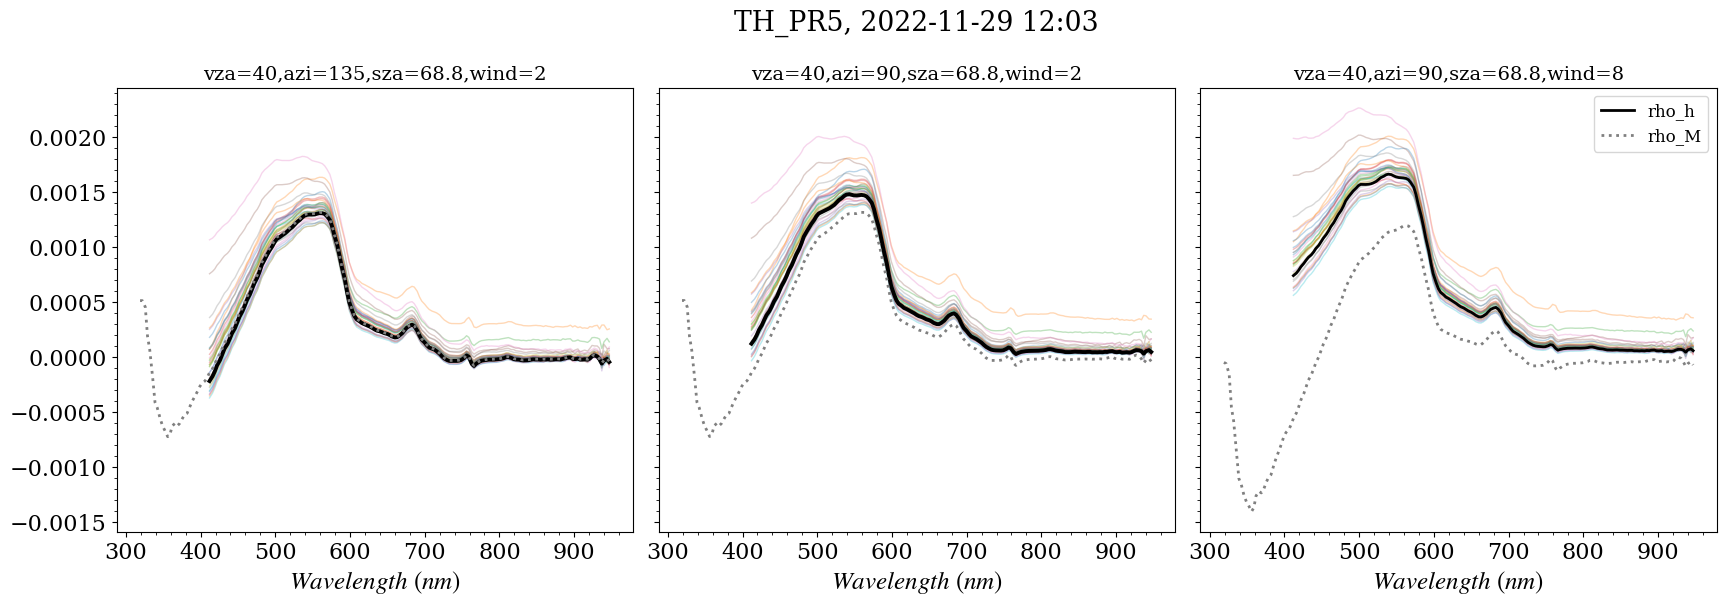

TH_PR6


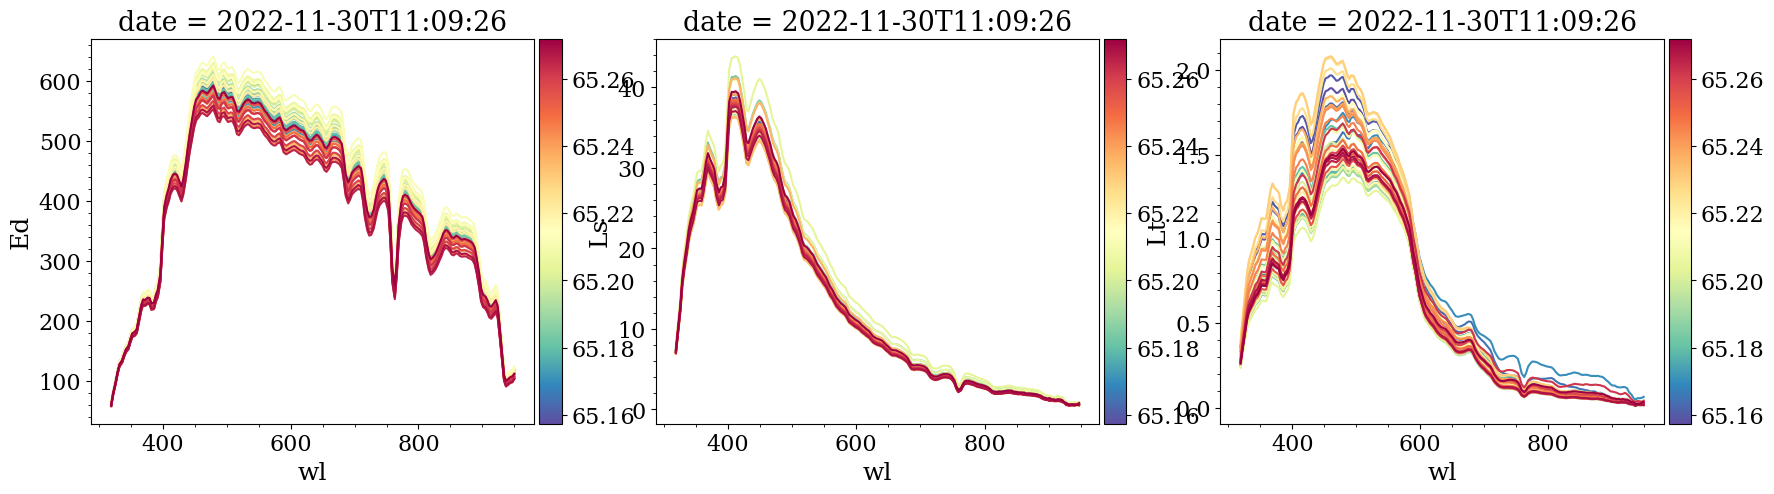

/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


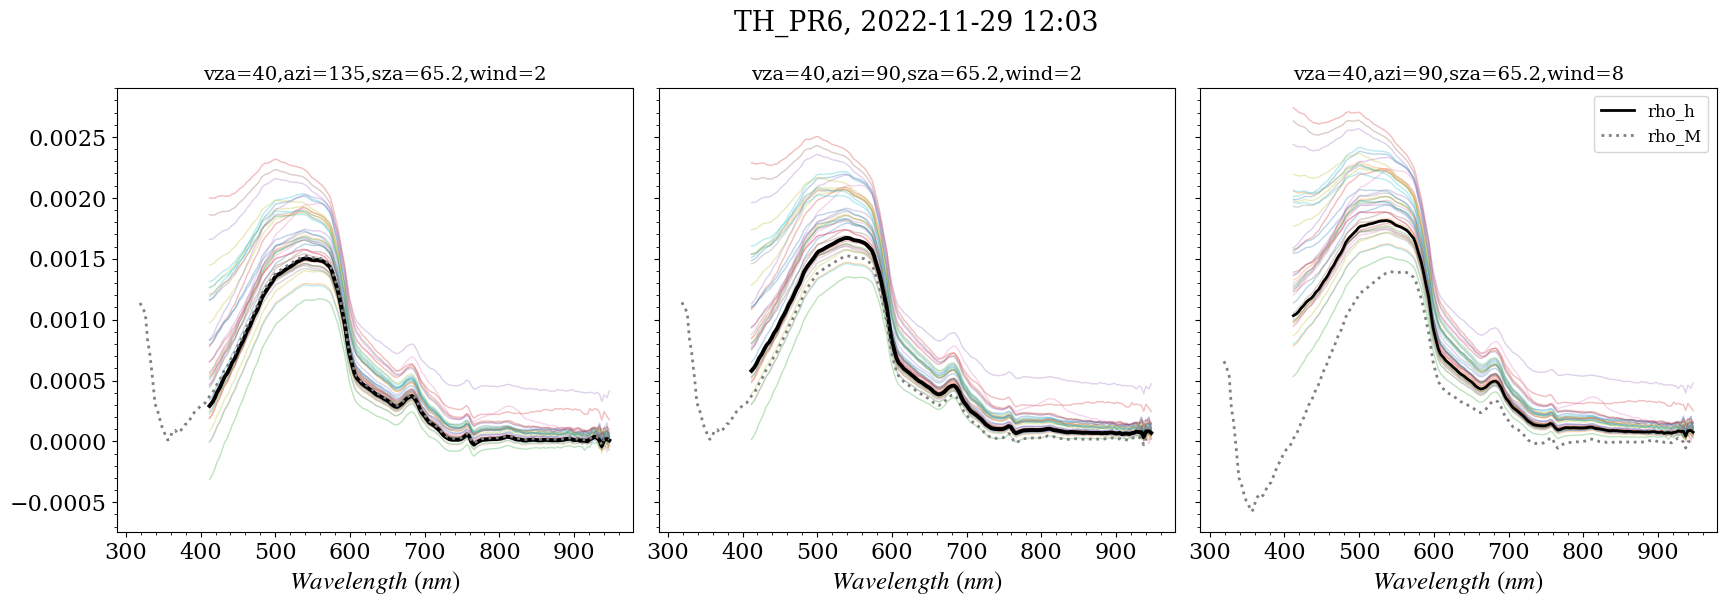

TH_PR7


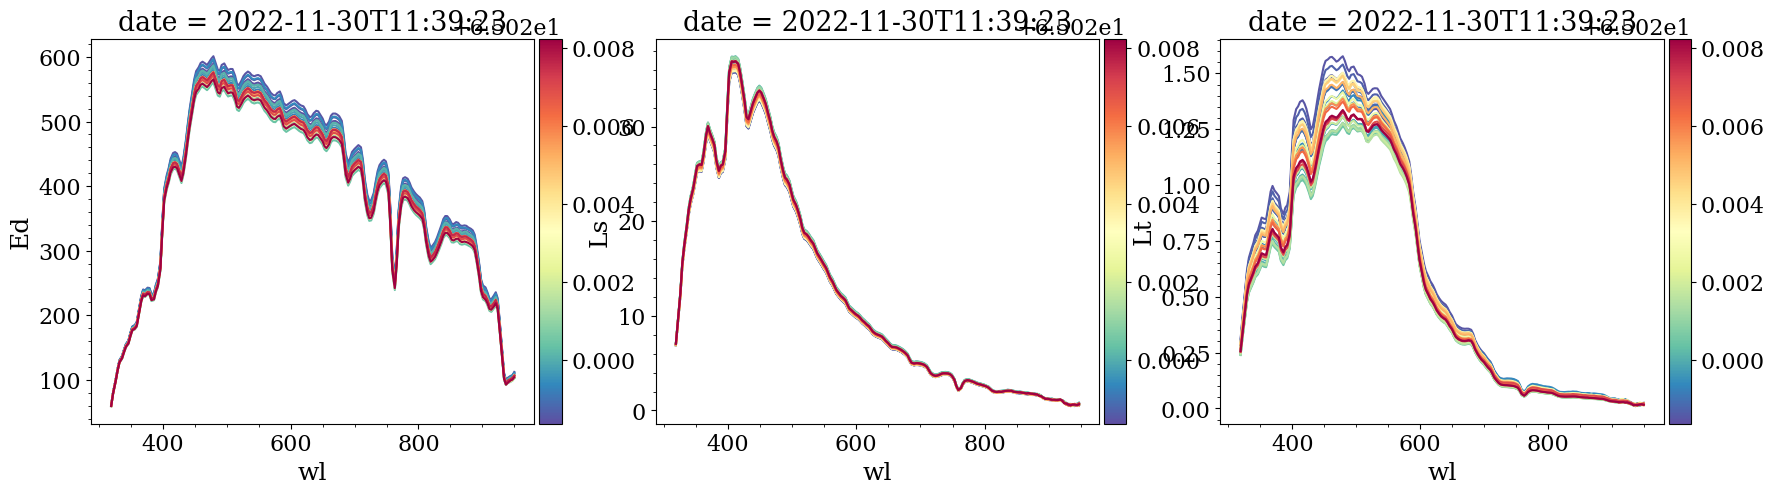

/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


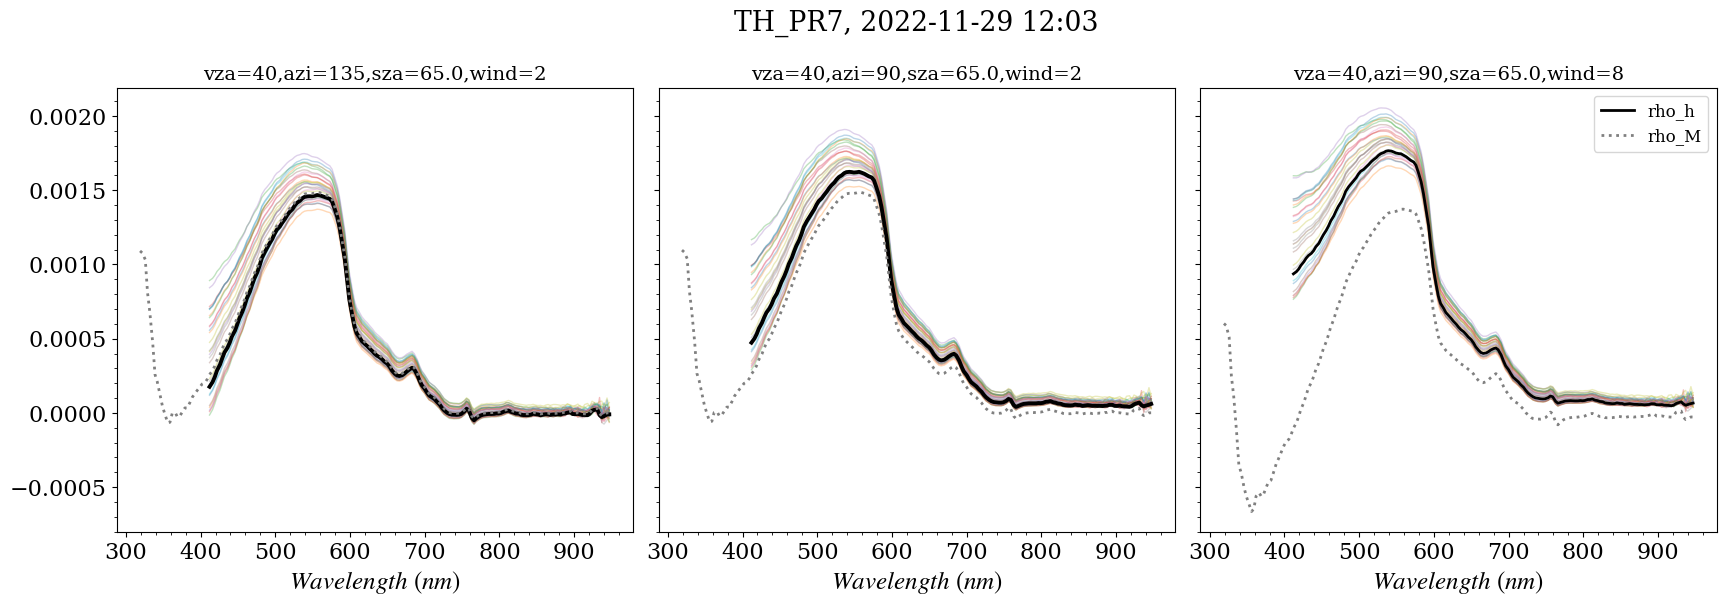

TH_PR8


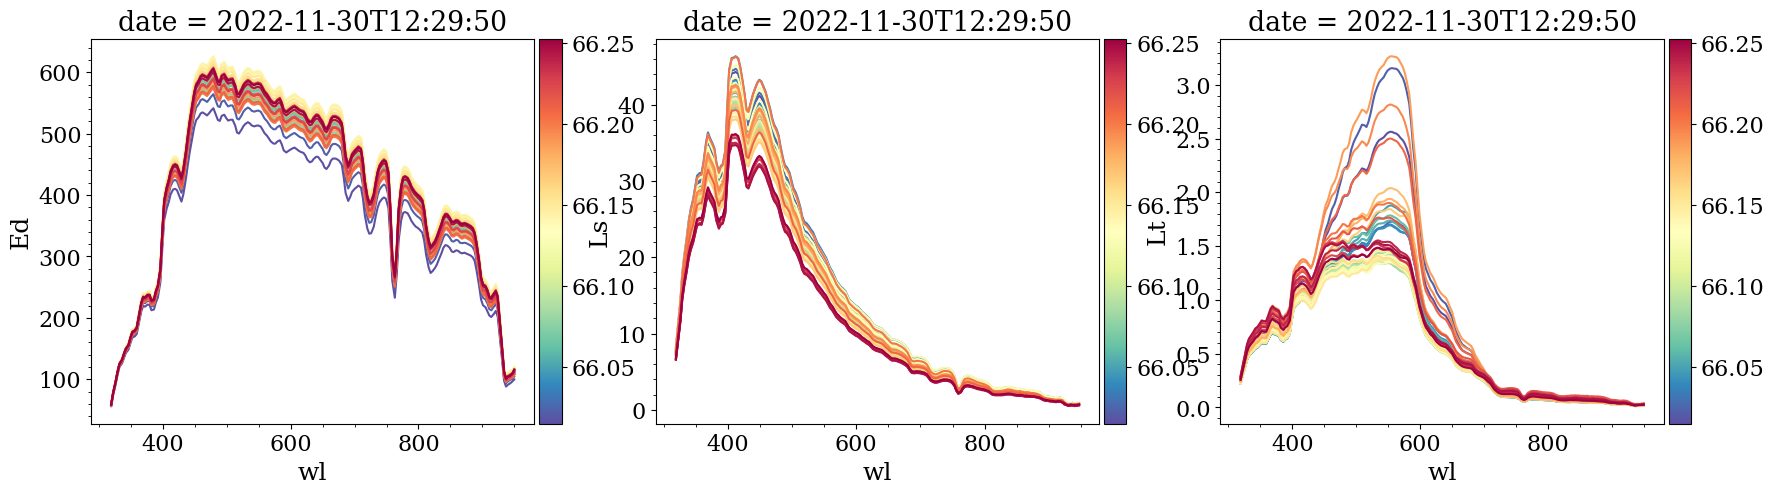

/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


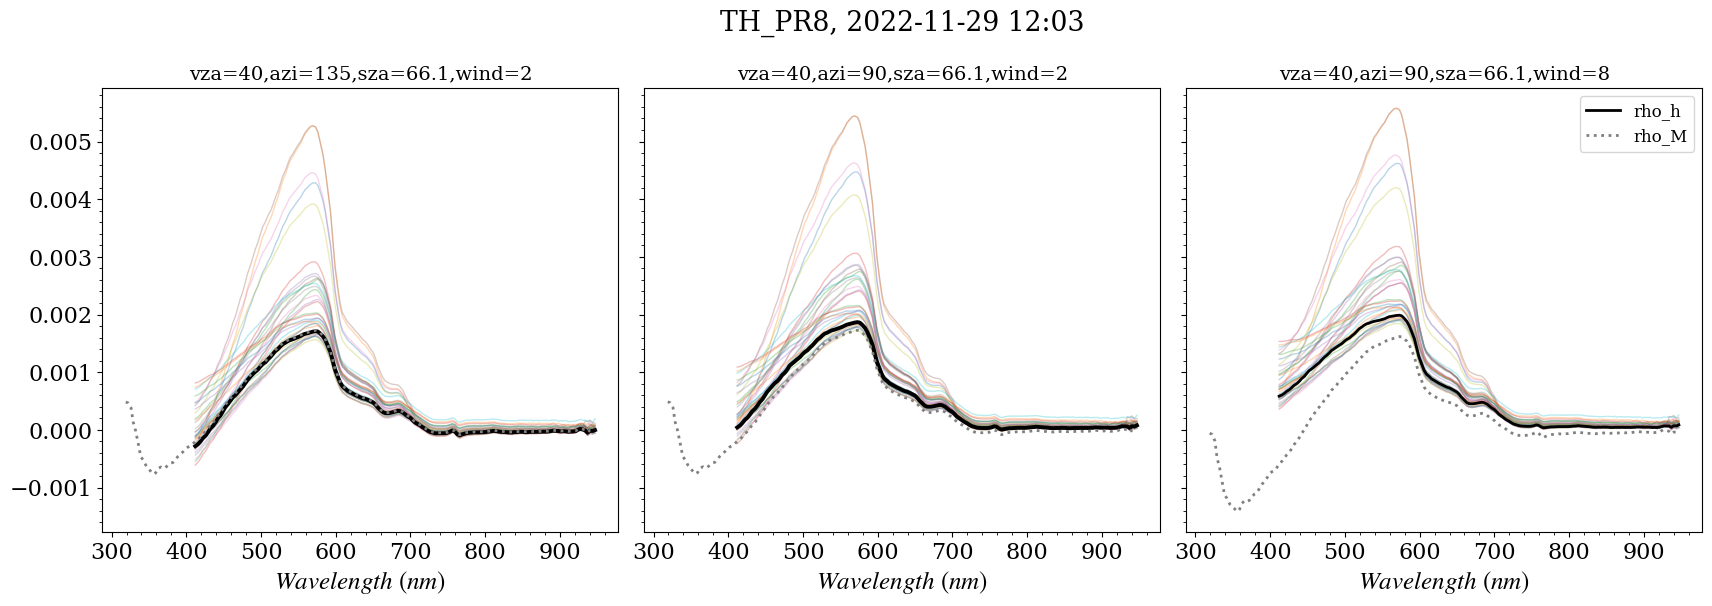

TH_PR9


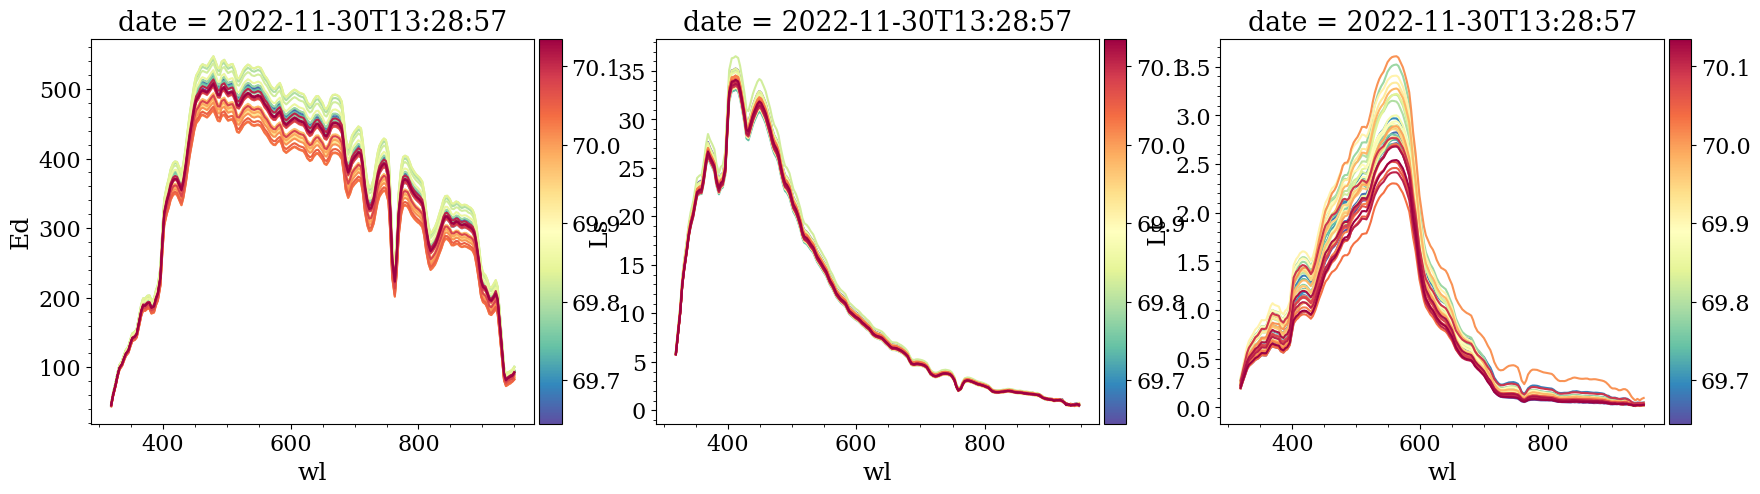

/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


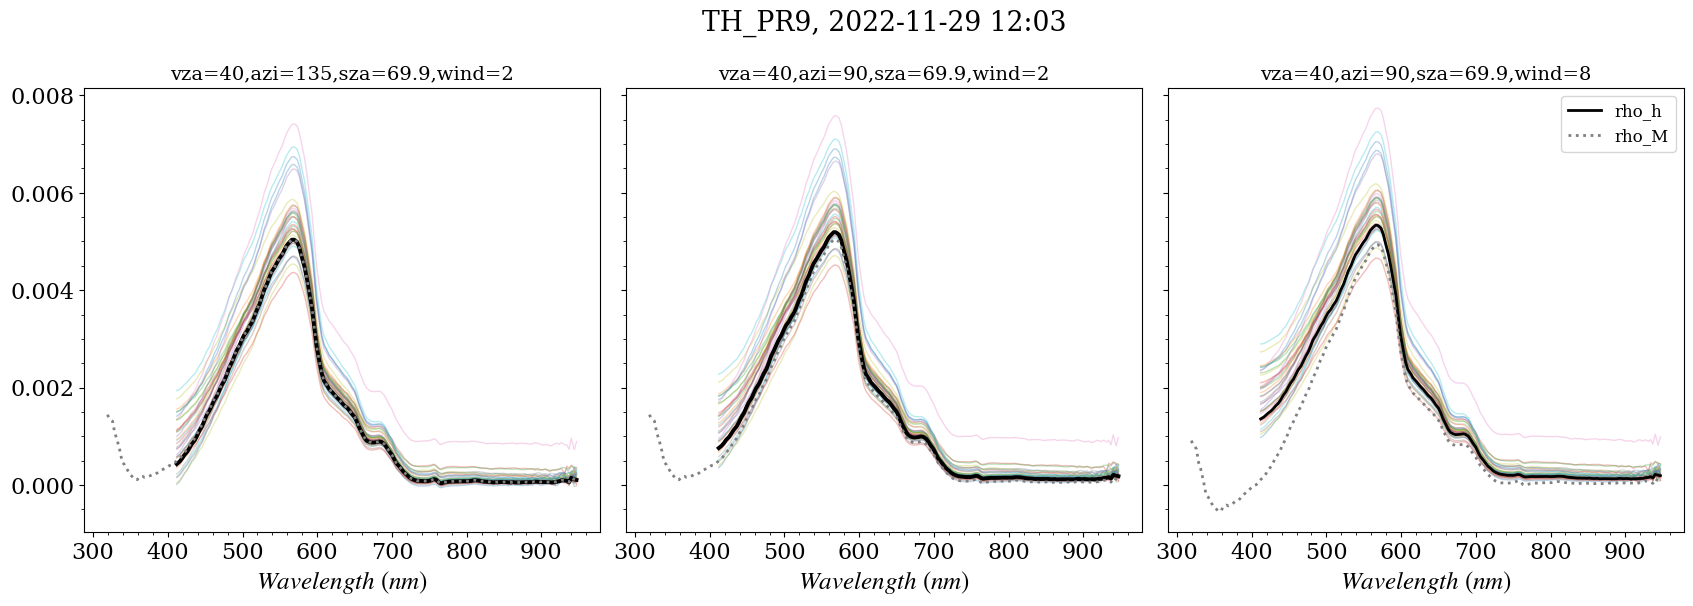

TH_PR10


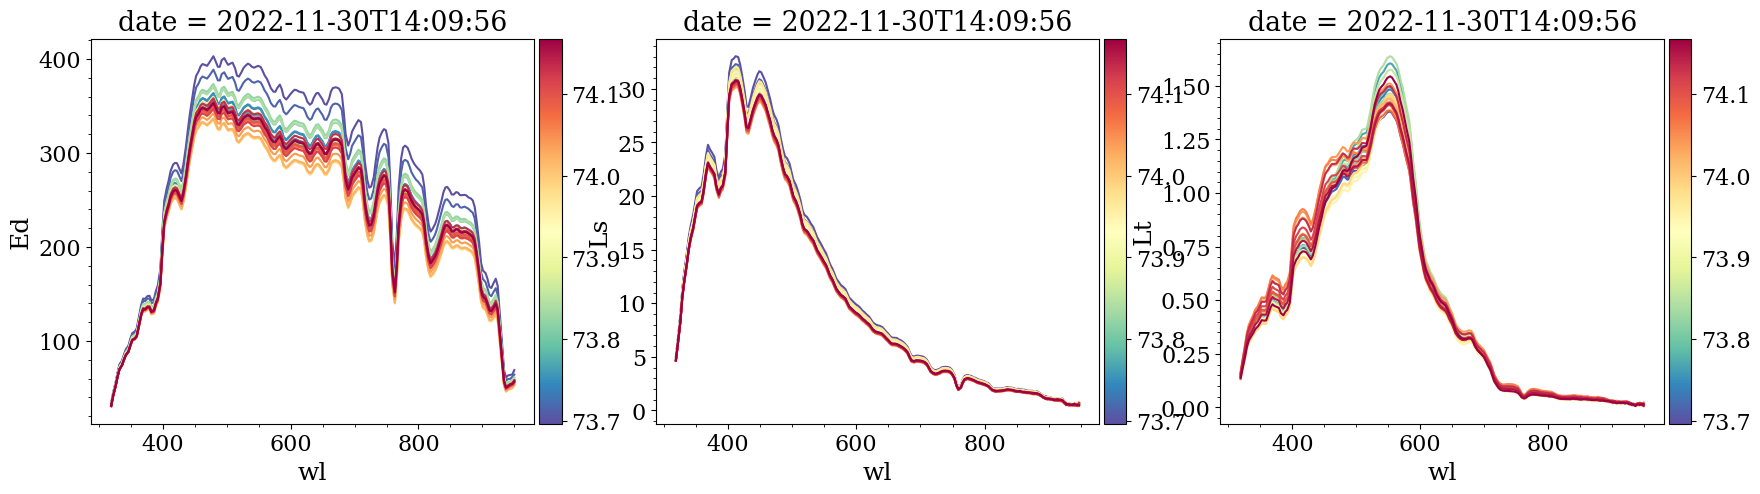

/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


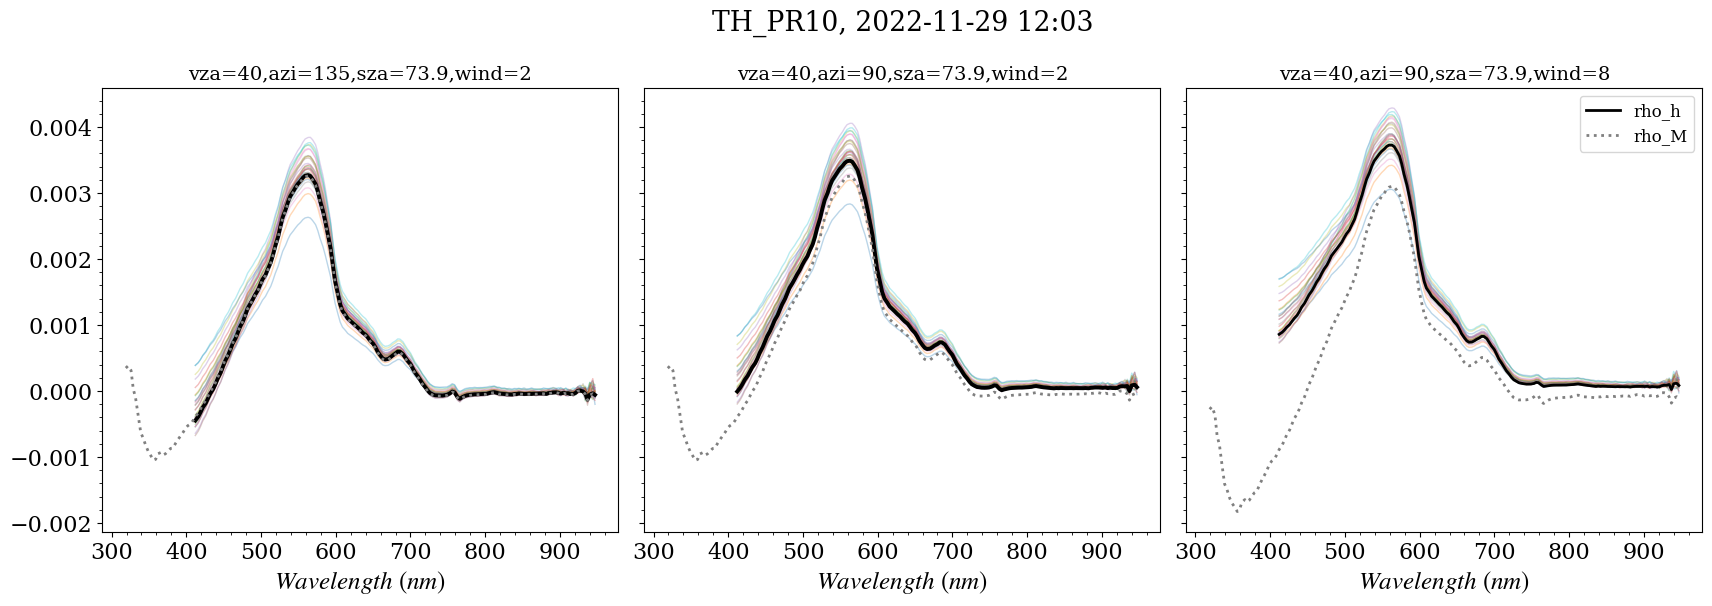

TH_PR11


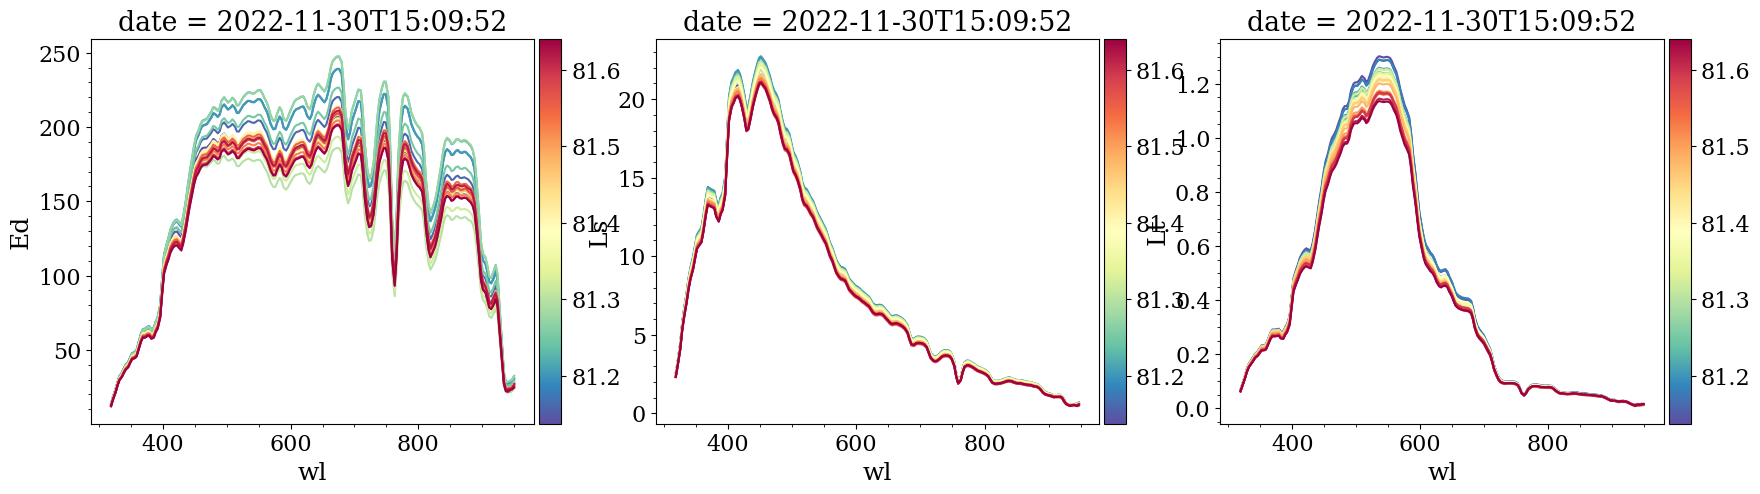

/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/harmel/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


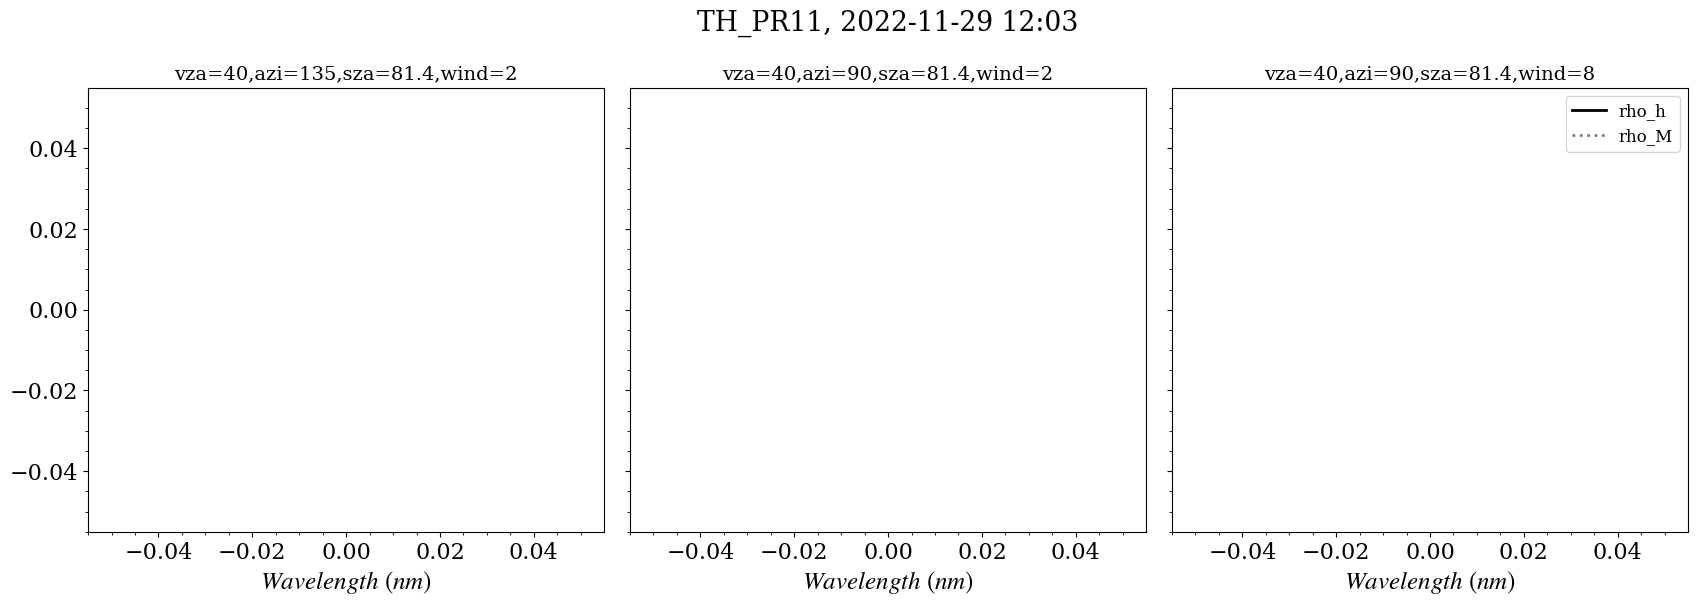

In [76]:
lon, lat = 3.6, 43.4
elevation=0

awr_fine = awr_process(wl=common_wl, aerosol = 'fine')
rho = awr_fine.get_rho_values #(60,40,135,wl=common_wl)
rho_mobley = awr_fine.get_rho_mobley
rho_mobley  = awr_fine.rhoM1999.to_xarray().rho
results=[]
cmap = plt.cm.Spectral_r
for id,rep in idpr.iterrows():
    rep=rep.rep
    print(rep)
    # set file paths
    Edfile = opj(datadir,rep,rep+' _ed.xlsx')
    Lsfile = opj(datadir,rep,rep+' _Ls.xlsx')
    Ltfile = opj(datadir,rep,rep+' _Lt.xlsx')
    # open and merge
    data = xr.merge([reshape_data(Edfile,name='Ed'),
              reshape_data(Lsfile,name='Ls'),
              reshape_data(Ltfile,name= 'Lt')])
    
   
    sun = suncalc.get_position(data.date,lon, lat)
    sza=90-np.degrees(sun['altitude'])
    data['sza'] = ('date',sza.values)
    date_str = str(date.dt.strftime('%Y-%m-%d %H:%M').values)
    
    norm = mpl.colors.Normalize(vmin=np.min(data.sza),vmax=np.max(data.sza))
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    fig.subplots_adjust(left=0.1, right=0.9, hspace=.1, wspace=0.2)
    for ii, var in enumerate(['Ed','Ls','Lt']):
        axs[ii].minorticks_on()
        for sza,data_ in data.groupby('sza'):
            data_[var].plot(c=cmap(norm(sza)),ax=axs[ii],add_legend=False)
            
        divider = make_axes_locatable(axs[ii])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = fig.colorbar(sm, cax=cax, format=mpl.ticker.ScalarFormatter(),
                            shrink=1.0, fraction=0.1, pad=0)
    plt.show()
    
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6),sharey=True)
    fig.subplots_adjust(left=0.1, right=0.9, top=0.85,hspace=.1, wspace=0.05)
    sza = data.sza.mean()
    azi=135
    vza=40
    wind=2
    rho_M = rho_mobley.sel(wind=wind).sel(azi=azi,vza=vza,method='nearest').interp(sza=sza,method='quadratic')
    Rrs=(data.Lt-rho(sza,vza,azi,ws=[wind],wl=common_wl)*data.Ls)/data.Ed
    Rrs_M=(data.Lt-rho_M*data.Ls)/data.Ed
    Rrs.plot(hue='date',add_legend=False,lw=1,ax=axs[0],alpha=0.3)
    Rrs.quantile(0.25,dim='date').plot(c='k',lw=2.8,ax=axs[0])
    Rrs_M.quantile(0.25,dim='date').plot(c='gray',ls=':',lw=2.,ax=axs[0],label='rho_M')
    axs[0].set_title('vza={:.0f},azi={:.0f},sza={:.1f},wind={:.0f}'.format(vza,azi,sza,wind),fontsize=14)
    
    azi=90
    vza=40
    rho_M = rho_mobley.sel(wind=wind).sel(azi=azi,vza=vza,method='nearest').interp(sza=sza,method='quadratic')
    Rrs=(data.Lt-rho(sza,vza,azi,ws=[wind],wl=common_wl)*data.Ls)/data.Ed
    Rrs_M=(data.Lt-rho_M*data.Ls)/data.Ed
    Rrs.plot(hue='date',add_legend=False,lw=1,ax=axs[1],alpha=0.3,label=None)
    Rrs.quantile(0.25,dim='date').plot(c='k',lw=2.8,ax=axs[1])
    Rrs_M.quantile(0.25,dim='date').plot(c='gray',ls=':',lw=2.,ax=axs[1],label='rho_M')
    axs[1].set_title('vza={:.0f},azi={:.0f},sza={:.1f},wind={:.0f}'.format(vza,azi,sza,wind),fontsize=14)
    
    wind=8
    rho_M = rho_mobley.sel(wind=wind).sel(azi=azi,vza=vza,method='nearest').interp(sza=sza,method='quadratic')
    Rrs=(data.Lt-rho(sza,vza,azi,ws=[wind],wl=common_wl)*data.Ls)/data.Ed
    Rrs_M=(data.Lt-rho_M*data.Ls)/data.Ed
    Rrs.plot(hue='date',add_legend=False,lw=1,ax=axs[2],alpha=0.3)
    Rrs.quantile(0.25,dim='date').plot(c='k',lw=2.,ax=axs[2],label='rho_h')
    Rrs_M.quantile(0.25,dim='date').plot(c='gray',ls=':',lw=2.,ax=axs[2],label='rho_M')
    axs[2].legend(fontsize=12)
    axs[2].set_title('vza={:.0f},azi={:.0f},sza={:.1f},wind={:.0f}'.format(vza,azi,sza,wind),fontsize=14)
    plt.suptitle(rep+', '+date_str)
    
    for ii in range(3):
        axs[ii].minorticks_on()
        axs[ii].set_xlabel('$Wavelength\ (nm)$')
    plt.show()
    
    
    # get results into xarray
    Rrs_output = Rrs.quantile(0.25,dim='date')
    Rrs_output['ID']=id
    Rrs_output['idpr']=rep
    Rrs_output['sza']=sza
    Rrs_output['date']=data.date.mean().values
    results.append(Rrs_output)

In [86]:
Rrs_L2 = xr.concat(results,dim='ID')
Rrs_L2.to_netcdf('/DATA/projet/magellium/malaigue/data/thau_nov2022/Rrs_TH34_2022.nc')

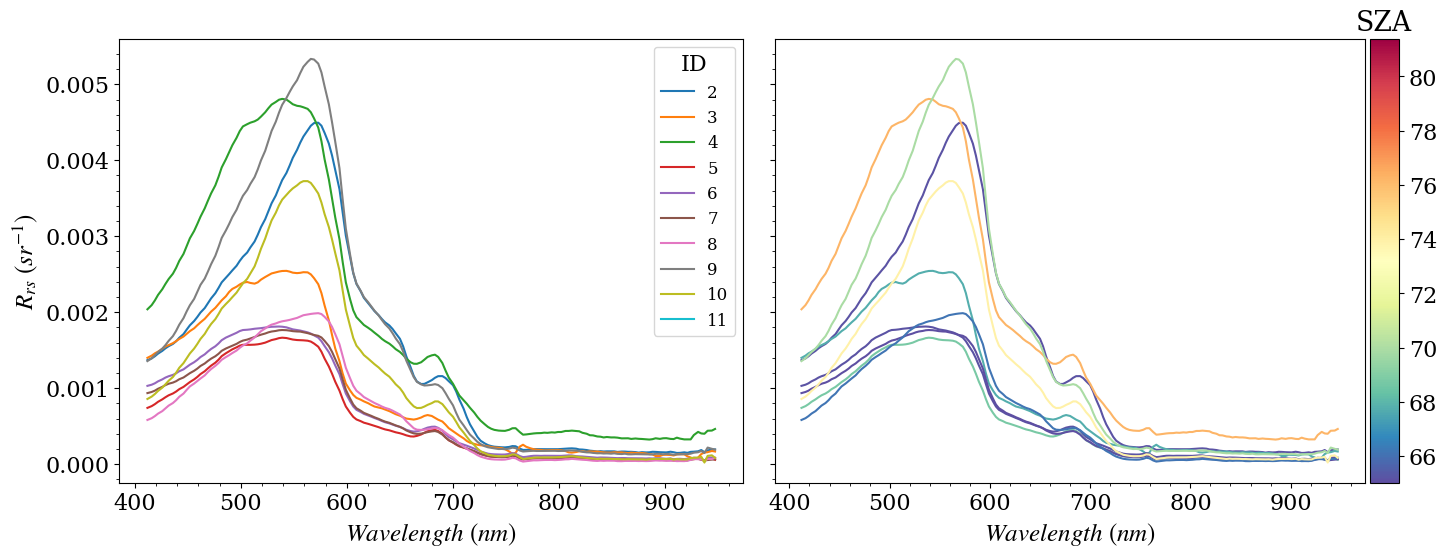

In [114]:
norm = mpl.colors.Normalize(vmin=np.min(Rrs_L2.sza),vmax=np.max(Rrs_L2.sza))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig, axs = plt.subplots(1,2, figsize=(16, 6),sharey=True)
fig.subplots_adjust(left=0.1, right=0.9, top=0.85,hspace=.1, wspace=0.05)
for id,Rrs_ in Rrs_L2.groupby('ID'):
    Rrs_.plot(label=str(id),ax=axs[0],add_legend=False)
    Rrs_.plot(c=cmap(norm(Rrs_.sza)),ax=axs[1],add_legend=False)

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sm, cax=cax, format=mpl.ticker.ScalarFormatter(),
                    shrink=1.0, fraction=0.1, pad=0)
cbar.ax.set_title('SZA')
axs[0].legend(title='ID',fontsize=12)
for ii in range(2):
    axs[ii].minorticks_on()
    axs[ii].set_xlabel('$Wavelength\ (nm)$')
    axs[ii].set_title('')
axs[0].set_ylabel('$R_{rs}\ (sr^{-1})$')
plt.show()